**Downloading quickdraw libraries**

# **Import libraries**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import numpy as np
from pathlib import Path
from quickdraw import QuickDrawDataGroup
from matplotlib import pyplot as plt
from PIL import Image
import torch
from torch import nn
from torch._C import device
from torch.utils.data import DataLoader


**Set the device**

In [ ]:
# Get cpu or gpu device (if available) for training.
if torch.cuda.is_available():
  device = torch.device("cuda")
print(f"Using {device} device")


**Defining the categories**

In [ ]:
animals = ("bat", "bee", "cat", "duck", "elephant", "lion", "octopus", "rabbit", "snail", "whale")
image_size_v = 64
image_size = (image_size_v, image_size_v)
max_drawings = 5000

**Making the directories for each animal**

In [ ]:
def download_animal(animal, image_size, max_drawings, recognized):
    
    directory = Path("data/" + animal)
    if not directory.exists():
        directory.mkdir(parents=True, exist_ok=True)

    imgs = QuickDrawDataGroup(animal, max_drawings=max_drawings, recognized=recognized)
    for img in imgs.drawings:
        filename = directory.as_posix() + "/" + str(img.key_id) + ".png"
        img.get_image(stroke_width=3).resize(image_size).save(filename)

In [ ]:
# uncomment this to download the images!

# for animal in animals:
#     download_animal(animal, image_size, max_drawings, recognized=True)

# **Defining dataset**

In [ ]:
# create dataloaders
training_dataloader = image_dataset_from_directory(
    directory="data", 
    subset="training",
    color_mode="grayscale",
    validation_split=0.2, 
    seed=42,
    batch_size=32,
    image_size=image_size)

validation_dataloader = image_dataset_from_directory(
    directory="data",
    subset="validation",
    color_mode="grayscale",
    validation_split=0.2,
    seed=42,
    batch_size=32,
    image_size=image_size)

# **Creating the model**

In [ ]:
# design model
model = tf.keras.Sequential([
    Rescaling(1./255, input_shape=(image_size_v, image_size_v, 1)), BatchNormalization(),

    Conv2D(16, 3, padding='same', activation='relu'),
    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

# **Compiling the model**

In [ ]:
optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=1e-3)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) 

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# **Training the model**

In [ ]:
epochs = 30

model.fit(training_dataloader, validation_data = validation_dataloader, epochs = epochs)

model.save("./models/final_model")

# **Testing accuracy**

In [37]:
test_loss, test_acc = model.evaluate(validation_dataloader, verbose=2)

/Users/anson/Library/Python/3.9/lib/python/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 - 8s - loss: 0.6840 - accuracy: 0.8648 - 8s/epoch - 25ms/step


**Input a random image**

In [36]:
# load in model
loaded_model = tf.keras.models.load_model("./models/final_model")

1/1 [==============================] - 0s 56ms/step
This doodle is of a ~ octopus ~!


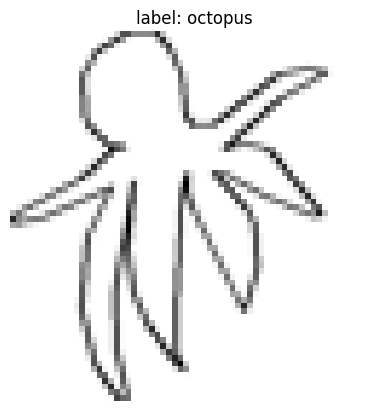

In [38]:
for images, labels in training_dataloader.take(1):  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
  
image_data = numpy_images[0].astype("uint8")
label_data = numpy_labels[0]
plt.axis("off")
plt.title("label: " + training_dataloader.class_names[label_data])
plt.imshow(image_data, cmap='gray', vmin=0, vmax=255)

reshaped_image = np.resize(image_data,(1, image_size_v, image_size_v, 1))
test_predictions = loaded_model.predict(reshaped_image)
result_index = np.argmax(test_predictions)
result_label = training_dataloader.class_names[result_index]
print(f"This doodle is of a ~ {result_label} ~!")
